# 1 Sistema de $N$ masas unidas con resortes

## 1.0. Modelo físico: $N$ masas acopladas

Consideremos $N$ masas idénticas, cada una de masa $m$, alineadas en una dimensión y unidas por resortes de constante elástica $k$.

- Supongamos que los extremos izquierdo y derecho están fijos.
- Llamaremos $u_j(t)$ al desplazamiento de la masa $j$ (respecto a su posición de equilibrio) en el tiempo $t$, para $j = 1,2,\dots,N$.
- Los extremos fijos se modelan como
  $$
  u_0(t) = 0, \qquad u_{N+1}(t) = 0.
  $$

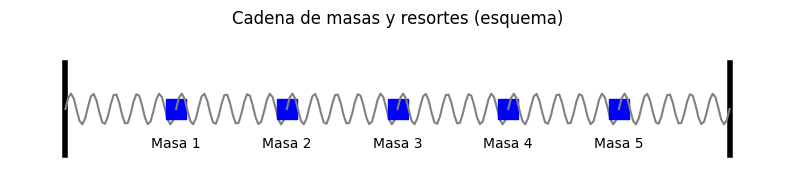

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact

# Create figure
fig, ax = plt.subplots(figsize=(10, 2))

m = 5  # number of masses
x_positions = np.linspace(1, m, m)

# Draw fixed walls
ax.plot([0, 0], [-0.3, 0.3], color='black', linewidth=4)
ax.plot([m+1, m+1], [-0.3, 0.3], color='black', linewidth=4)

# Draw springs and masses
for i in range(m):
    # Spring from left wall or previous mass
    x0 = 0 if i == 0 else x_positions[i-1]
    x1 = x_positions[i]
    xs = np.linspace(x0, x1, 40)
    ys = 0.1 * np.sin(10 * np.pi * (xs - x0) / (x1 - x0))
    ax.plot(xs, ys, color='gray')

    # Mass
    ax.plot(x_positions[i], 0, 's', color='blue', markersize=15)
    ax.text(x_positions[i], -0.25, f'Masa {i+1}', ha='center')

# Spring from last mass to right wall
x0 = x_positions[-1]
x1 = m+1
xs = np.linspace(x0, x1, 40)
ys = 0.1 * np.sin(10 * np.pi * (xs - x0) / (x1 - x0))
ax.plot(xs, ys, color='gray')

ax.set_xlim(-0.5, m+1.5)
ax.set_ylim(-0.5, 0.5)
ax.set_axis_off()

plt.title("Cadena de masas y resortes (esquema)")
plt.show()


## 1.1. Fuerzas sobre la masa $j$

Para una masa interior $j$ (es decir, $1 \le j \le N$), las fuerzas provienen de los resortes que la unen con sus vecinos izquierdo y derecho:

- Resorte con la masa $j-1$: fuerza proporcional a la diferencia $u_{j-1} - u_j$.
- Resorte con la masa $j+1$: fuerza proporcional a la diferencia $u_{j+1} - u_j$.

Por la ley de Hooke, la fuerza neta sobre la masa $j$ es

$$
F_j = k(u_{j+1} - u_j) + k(u_{j-1} - u_j)
    = k\big(u_{j+1} - 2u_j + u_{j-1}\big).
$$

Por la segunda ley de Newton, $F_j = m \ddot u_j$, de modo que

$$
m \ddot u_j(t) = k\big(u_{j+1}(t) - 2u_j(t) + u_{j-1}(t)\big),
\qquad j = 1,2,\dots,N,
$$

con condiciones de frontera fijas

$$
u_0(t) = 0, \qquad u_{N+1}(t) = 0.
$$

Estas son ecuaciones diferenciales de segundo orden acopladas.

## 1.2. Sistema equivalente de primer orden

Para usar métodos numéricos estándar, escribimos el sistema como un sistema de primer orden.

Definimos, para cada $j$:

- $x_j(t) = u_j(t)$ (posición),
- $v_j(t) = \dot u_j(t)$ (velocidad).

Entonces

- $\dot x_j(t) = v_j(t)$,
- $\dot v_j(t) = \ddot u_j(t) = \dfrac{k}{m}(u_{j+1} - 2u_j + u_{j-1})$.

Es decir,

$$
\dot x_j(t) = v_j(t), \qquad j=1,\dots,N,
$$

$$
\dot v_j(t) = \frac{k}{m}\big(x_{j+1}(t) - 2x_j(t) + x_{j-1}(t)\big),
\qquad j=1,\dots,N,
$$

con

$$
x_0(t) = 0, \qquad x_{N+1}(t) = 0.
$$

En forma vectorial, si definimos el vector

$$
y(t) =
\begin{pmatrix}
x_1(t) \\ \vdots \\ x_N(t) \\
v_1(t) \\ \vdots \\ v_N(t)
\end{pmatrix} \in \mathbb{R}^{2N},
$$

podemos escribir el sistema como

$$
\dot y(t) = f(t, y(t)).
$$

In [2]:
def sistema_masas_resortes(t, y, masa, k_resorte, numero_masas):
    """
    Calcula el campo de derivadas para el sistema de N masas unidas por resortes
    con extremos fijos.

    El vector de estado y tiene la forma:
        y = [x_1, x_2, ..., x_N, v_1, v_2, ..., v_N],

    donde:
        x_j = desplazamiento de la masa j,
        v_j = velocidad de la masa j.

    Parámetros
    ----------
    t : float
        Tiempo actual (no se usa explícitamente porque el sistema es autónomo,
        pero se incluye para compatibilidad con interfaces estándar).
    y : np.ndarray
        Vector de estado de dimensión 2*N.
    masa : float
        Masa de cada partícula (se asume igual para todas).
    k_resorte : float
        Constante elástica de los resortes (se asume igual para todos).
    numero_masas : int
        Número total de masas N.

    Regresa
    -------
    derivadas : np.ndarray
        Vector de derivadas dy/dt, de la misma dimensión que y.
    """
    # Separar posiciones y velocidades
    x = y[:numero_masas]         # x_1, ..., x_N
    v = y[numero_masas:]         # v_1, ..., v_N

    # Inicializar arreglo de derivadas
    derivadas = np.zeros_like(y)

    # Ecuaciones para las posiciones: dx_j/dt = v_j
    derivadas[:numero_masas] = v

    # Ecuaciones para las velocidades: dv_j/dt = (k/m)*(x_{j+1} - 2x_j + x_{j-1})
    aceleraciones = np.zeros(numero_masas)

    # Consideramos extremos fijos: x_0 = 0, x_{N+1} = 0
    for j in range(numero_masas):
        if j == 0:
            x_izquierda = 0.0
        else:
            x_izquierda = x[j - 1]

        if j == numero_masas - 1:
            x_derecha = 0.0
        else:
            x_derecha = x[j + 1]

        aceleraciones[j] = (k_resorte / masa) * (x_derecha - 2.0 * x[j] + x_izquierda)

    derivadas[numero_masas:] = aceleraciones

    return derivadas


## 1.3. Método numérico: Runge–Kutta de orden 4 (RK4)

Para aproximar la solución del sistema $\dot y = f(t,y)$, usaremos el método de Runge–Kutta clásico de orden 4.

Dado un paso de tamaño $h$ y un estado actual $(t_n, y_n)$:

1. $k_1 = f(t_n, y_n)$
2. $k_2 = f(t_n + \tfrac{h}{2}, y_n + \tfrac{h}{2}k_1)$
3. $k_3 = f(t_n + \tfrac{h}{2}, y_n + \tfrac{h}{2}k_2)$
4. $k_4 = f(t_n + h, y_n + h k_3)$

Entonces, el siguiente valor se define como

$$
y_{n+1} = y_n + \frac{h}{6}\big(k_1 + 2k_2 + 2k_3 + k_4\big).
$$


In [3]:
def integrar_rk4(funcion_f, t_inicial, t_final, y_inicial, numero_pasos, *args_funcion):
    """
    Integra un sistema de EDOs usando el método de Runge–Kutta clásico de orden 4 (RK4).

    El sistema tiene la forma:
        dy/dt = funcion_f(t, y, *args_funcion)

    Parámetros
    ----------
    funcion_f : callable
        Función que define el campo de derivadas. Debe tener firma
        funcion_f(t, y, *args_funcion) y regresar un np.ndarray de la
        misma dimensión que y.
    t_inicial : float
        Tiempo inicial de la integración.
    t_final : float
        Tiempo final de la integración.
    y_inicial : np.ndarray
        Vector de estado inicial.
    numero_pasos : int
        Número de pasos de integración. El tamaño de paso será
        h = (t_final - t_inicial) / numero_pasos.
    *args_funcion :
        Parámetros adicionales que se pasan directamente a funcion_f.

    Regresa
    -------
    tiempos : np.ndarray
        Arreglo de tiempos de longitud numero_pasos + 1.
    soluciones : np.ndarray
        Arreglo de soluciones. Es una matriz de tamaño
        (numero_pasos + 1, dimension_del_estado), donde cada fila
        corresponde al estado y(t) en un tiempo de 'tiempos'.
    """
    # Convertir el estado inicial a arreglo de NumPy (por seguridad)
    y_actual = np.array(y_inicial, dtype=float)

    # Construir malla temporal
    tiempos = np.linspace(t_inicial, t_final, numero_pasos + 1)
    h = (t_final - t_inicial) / numero_pasos

    # Reservar memoria para las soluciones
    dimension_estado = len(y_actual)
    soluciones = np.zeros((numero_pasos + 1, dimension_estado))
    soluciones[0, :] = y_actual

    # Bucle principal de integración
    for n in range(numero_pasos):
        t_n = tiempos[n]

        k1 = funcion_f(t_n, y_actual, *args_funcion)
        k2 = funcion_f(t_n + 0.5 * h, y_actual + 0.5 * h * k1, *args_funcion)
        k3 = funcion_f(t_n + 0.5 * h, y_actual + 0.5 * h * k2, *args_funcion)
        k4 = funcion_f(t_n + h, y_actual + h * k3, *args_funcion)

        incremento = (h / 6.0) * (k1 + 2.0 * k2 + 2.0 * k3 + k4)
        y_actual = y_actual + incremento

        soluciones[n + 1, :] = y_actual

    return tiempos, soluciones



## 1.4. Condiciones iniciales para el sistema de masas y resortes

Para cerrar el problema necesitamos condiciones iniciales:

- Desplazamientos iniciales $x_j(0)$.
- Velocidades iniciales $v_j(0)$.

Una elección típica es:

- Desplazar las masas según un "modo" senoidal (como el primer modo de vibración),
- Velocidades iniciales iguales a cero.

Por ejemplo:

$$
x_j(0) = A \sin\left(\frac{\text{modo}\cdot\pi j}{N+1}\right), \qquad v_j(0) = 0,
\quad j = 1,\dots,N,
$$

donde $A$ es una amplitud inicial. Aquí tomamos $A=1$.

[Vibrating String - Normal Modes](https://youtu.be/BSIw5SgUirg?si=5w-s7NIOHLiYezR_)

In [8]:
def construir_condicion_inicial(numero_masas, amplitud=1.0, modo=1):
    """
    Construye una condición inicial para el sistema de N masas y resortes.

    La condición inicial se define como:
        x_j(0) = amplitud * sin(modo * pi * j / (N + 1)),
        v_j(0) = 0,
    para j = 1, ..., N.

    Parámetros
    ----------
    numero_masas : int
        Número total de masas N.
    amplitud : float, opcional
        Amplitud del desplazamiento (por defecto 1.0).
    modo : int, opcional
        Modo normal escogido para la condición inicial.
        Debe estar entre 1 y N.

    Regresa
    -------
    y0 : np.ndarray
        Vector de estado inicial de dimensión 2*N:
        y0 = [x_1(0), ..., x_N(0), v_1(0), ..., v_N(0)].
    """

    # Asegurar que el modo es válido
    modo = int(modo)
    if modo < 1 or modo > numero_masas:
        raise ValueError(f"El modo debe estar entre 1 y {numero_masas}.")

    indices = np.arange(1, numero_masas + 1, dtype=float)

    # Perfil espacial del modo solicitado
    posiciones_iniciales = amplitud * np.sin(modo * np.pi * indices / (numero_masas + 1))

    # Velocidades iniciales cero
    velocidades_iniciales = np.zeros(numero_masas, dtype=float)

    # Concatenar posiciones y velocidades
    y0 = np.concatenate([posiciones_iniciales, velocidades_iniciales])
    return y0


## 1.5. Visualización: desplazamiento de las masas

In [ ]:
# Visualización interactiva
# ------------------------------------------------------------
# Parámetros globales base del sistema
# ------------------------------------------------------------

m = 1.0            # masa de cada partícula
k = 1.0            # constante elástica
t0 = 0.0           # tiempo inicial
tf = 50.0          # tiempo final
pasos = 5000       # número de pasos RK4
amplitud_inicial = 1.0
offset = 2.0       # separación vertical entre curvas


# ------------------------------------------------------------
# Función para graficar con modo y N variables
# ------------------------------------------------------------

def graficar_masas(N, modo):
    """
    Integra el sistema con el número de masas N y el modo indicado.
    Grafica el desplazamiento de cada masa en su propio nivel.
    """
    N = int(N)
    modo = int(modo)

    # Asegurar que el modo esté dentro del rango
    if modo < 1:
        modo = 1
    if modo > N:
        modo = N

    # Construir condición inicial
    y0 = construir_condicion_inicial(N, amplitud=amplitud_inicial, modo=modo)

    # Integrar sistema
    tiempos, soluciones = integrar_rk4(
        sistema_masas_resortes,
        t0, tf, y0, pasos,
        m, k, N
    )

    posiciones = soluciones[:, :N]

    plt.figure(figsize=(10, 8))

    # Graficar del fondo al frente
    for idx in reversed(range(N)):
        plt.plot(
            tiempos,
            posiciones[:, idx] + offset * idx,
            label=f"Masa {idx + 1}"
        )

    plt.xlabel("Tiempo")
    plt.ylabel("Desplazamientos (con offset por masa)")
    plt.title(f"{N} masas — modo inicial = {modo}")
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.show()


# ------------------------------------------------------------
# Sliders para elegir N y modo
# ------------------------------------------------------------

slider_N = widgets.IntSlider(
    value=10,
    min=2,
    max=40,
    step=1,
    description='N masas:'
)

slider_modo = widgets.IntSlider(
    value=1,
    min=1,
    max=40,    # luego se ajusta dentro de la función si N < modo
    step=1,
    description='Modo:'
)

interact(graficar_masas, N=slider_N, modo=slider_modo);


interactive(children=(IntSlider(value=10, description='N masas:', max=40, min=2), IntSlider(value=1, descripti…

In [ ]:
# Grafica interactiva del desplazamiento de las masas
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact

# -------------------------------------------------------------------
# Condición inicial con modo
# -------------------------------------------------------------------

def condicion_inicial_modo(N, modo=1, amplitud=1.0):
    """
    Define la condición inicial de las masas para un modo normal dado.

    x_j(0) = amplitud * sin(modo * pi * j / (N + 1)),
    v_j(0) = 0.

    Parámetros
    ----------
    N : int
        Número de masas en la cadena.
    modo : int
        Modo normal (1, 2, ..., N).
    amplitud : float
        Amplitud del modo.

    Regresa
    -------
    u0 : ndarray de forma (N,)
        Desplazamientos iniciales.
    v0 : ndarray de forma (N,)
        Velocidades iniciales (todas cero).
    """
    modo = int(modo)
    if modo < 1 or modo > N:
        raise ValueError(f"El modo debe estar entre 1 y {N}.")

    indices = np.arange(1, N+1)
    u0 = amplitud * np.sin(modo * np.pi * indices / (N + 1))
    v0 = np.zeros_like(u0)
    return u0, v0


# -------------------------------------------------------------------
# Modelo de N masas y resortes
# -------------------------------------------------------------------

def calcular_aceleracion(u, k=1.0, m=1.0):
    """
    Calcula la aceleración de cada masa dada la posición actual.

    Parámetros
    ----------
    u : ndarray de forma (N,)
        Desplazamientos actuales de las masas.
    k : float
        Constante del resorte (igual para todos los resortes).
    m : float
        Masa de cada partícula (todas iguales).

    Regresa
    -------
    a : ndarray de forma (N,)
        Aceleraciones de cada masa.
    """
    N = len(u)
    a = np.zeros_like(u)

    # Extendemos con condiciones de frontera fijas
    u_ext = np.zeros(N + 2)
    u_ext[1:-1] = u  # u_ext[0] = 0, u_ext[-1] = 0

    # Laplaciano discreto en los puntos interiores 1,...,N
    for j in range(1, N+1):
        a[j-1] = k * (u_ext[j+1] - 2.0 * u_ext[j] + u_ext[j-1]) / m

    return a


def simular_masas(N, modo=1, amplitud=1.0, T_max=10.0, dt=0.01, k=1.0, m=1.0):
    """
    Simula la evolución temporal de una cadena de N masas y resortes,
    usando como condición inicial el modo dado.

    Parámetros
    ----------
    N : int
        Número de masas.
    modo : int
        Modo normal para la condición inicial.
    amplitud : float
        Amplitud del modo inicial.
    T_max : float
        Tiempo total de simulación.
    dt : float
        Paso de tiempo.
    k : float
        Constante de los resortes.
    m : float
        Masa de cada partícula.

    Regresa
    -------
    tiempos : ndarray de forma (num_pasos+1,)
        Tiempos de la simulación.
    U : ndarray de forma (num_pasos+1, N)
        Desplazamientos de cada masa en cada tiempo.
    """
    num_pasos = int(np.round(T_max / dt))
    tiempos = np.linspace(0.0, T_max, num_pasos + 1)

    # Condición inicial según el modo
    u, v = condicion_inicial_modo(N, modo=modo, amplitud=amplitud)

    U = np.zeros((num_pasos + 1, N))
    U[0, :] = u

    a = calcular_aceleracion(u, k=k, m=m)

    for n in range(num_pasos):
        # Integrador de Verlet (simplectico)
        v_med = v + 0.5 * dt * a
        u_new = u + dt * v_med
        a_new = calcular_aceleracion(u_new, k=k, m=m)
        v_new = v_med + 0.5 * dt * a_new

        u, v, a = u_new, v_new, a_new
        U[n+1, :] = u

    return tiempos, U


# -------------------------------------------------------------------
# Visualización interactiva
# -------------------------------------------------------------------

T_MAX_GLOBAL = 50.0
DT_GLOBAL = 0.01
AMPLITUD_GLOBAL = 1.0

def visualizar_cadena(N=10, modo=1, t=0.0):
    """
    Visualiza la posición de N masas conectadas por resortes en un tiempo t,
    usando el modo dado como condición inicial. Incluye extremos fijos en rojo.
    """
    N = max(2, int(N))

    # Aseguramos que el modo no exceda N (por si el slider tiene valor mayor)
    modo = int(modo)
    if modo > N:
        modo = N
    if modo < 1:
        modo = 1

    tiempos, U = simular_masas(
        N,
        modo=modo,
        amplitud=AMPLITUD_GLOBAL,
        T_max=T_MAX_GLOBAL,
        dt=DT_GLOBAL
    )

    t = np.clip(t, 0.0, T_MAX_GLOBAL)
    idx = int(np.round(t / DT_GLOBAL))
    idx = min(idx, len(tiempos) - 1)

    u_t = U[idx, :]
    x_masas = np.arange(1, N+1)

    # Vector extendido con extremos fijos
    x_ext = np.arange(0, N+2)   # 0,1,...,N,N+1
    u_ext = np.zeros(N+2)
    u_ext[1:-1] = u_t

    plt.figure(figsize=(8, 4))

    # Línea que une todos los puntos (incluyendo extremos)
    plt.plot(x_ext, u_ext, linestyle='-', color='gray')

    # Masas interiores (azules)
    plt.scatter(x_masas, u_t, color='blue', label='Masas móviles')

    # Masas fijas de los extremos (rojas)
    plt.scatter([0, N+1], [0.0, 0.0], color='red', label='Extremos fijos')

    plt.title(
        f"Cadena de N masas y resortes (N={N}), modo={modo}, t ≈ {tiempos[idx]:.2f}"
    )
    plt.xlabel("Índice de masa (posición horizontal)")
    plt.ylabel("Desplazamiento vertical")
    plt.grid(True)
    plt.ylim(-1.5, 1.5)
    plt.xlim(-0.5, N+1.5)
    plt.legend()
    plt.show()


# Sliders
slider_N = widgets.IntSlider(
    value=10,
    min=2,
    max=40,
    step=1,
    description='N masas:',
    continuous_update=False
)

slider_modo = widgets.IntSlider(
    value=1,
    min=1,
    max=8,   # si N < 20, dentro de la función se recorta a N
    step=1,
    description='Modo:',
    continuous_update=False
)

slider_t = widgets.FloatSlider(
    value=0.0,
    min=0.0,
    max=T_MAX_GLOBAL,
    step=0.05,
    description='Tiempo t:',
    continuous_update=True
)

interact(visualizar_cadena, N=slider_N, modo=slider_modo, t=slider_t);


interactive(children=(IntSlider(value=10, continuous_update=False, description='N masas:', max=40, min=2), Int…

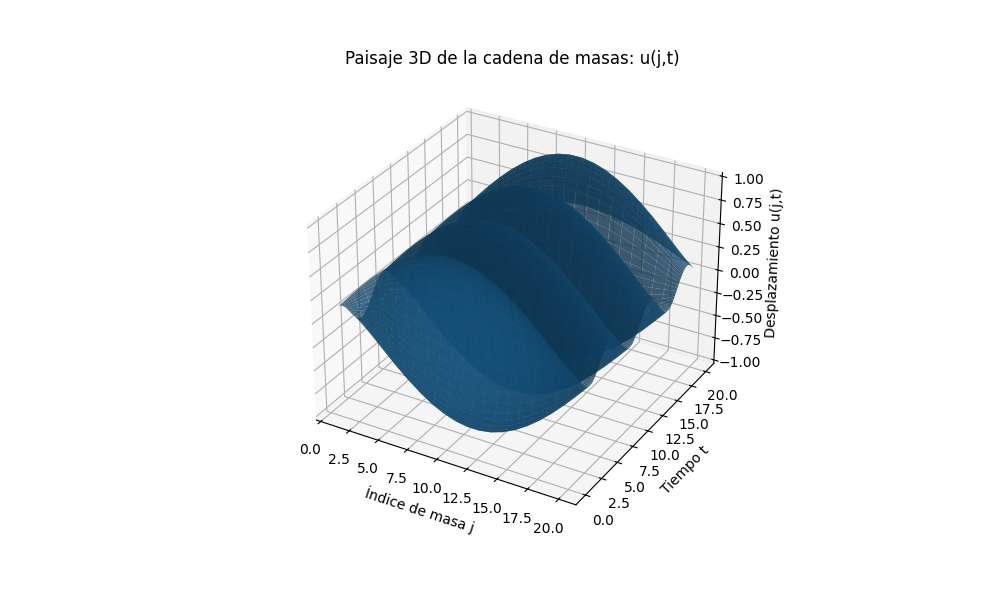

: 

In [ ]:
# Visualización 3D del desplazamiento de las masas
# Parámetros y "solución" del sistema de N masas
%matplotlib widget
def generar_malla_y_solucion(N=20, T_max=20.0, num_t=400, omega=1.0):
    """
    Genera la malla (j, t) y la solución u(j,t) para el modo fundamental
    de una cadena de N masas con extremos fijos.

    Parámetros
    ----------
    N : int
        Número de masas.
    T_max : float
        Tiempo máximo de la simulación.
    num_t : int
        Número de puntos en el tiempo.
    omega : float
        Frecuencia angular de oscilación.

    Regresa
    -------
    j_indices : ndarray de forma (N,)
        Índices de las masas: 1,2,...,N.
    t : ndarray de forma (num_t,)
        Tiempos de la simulación.
    U : ndarray de forma (N, num_t)
        Desplazamientos u(j,t) para cada j y t.
    """
    # Malla en espacio (índice de masa) y tiempo
    j_indices = np.arange(1, N+1)           # j = 1,...,N
    t = np.linspace(0.0, T_max, num_t)      # tiempos

    # Modo fundamental (perfil senoidal en espacio y coseno en tiempo)
    # U[j-1, n] = sin(pi j/(N+1)) * cos(omega * t_n)
    perfil_espacial = np.sin(np.pi * j_indices / (N + 1))[:, None]  # (N,1)
    oscilacion_temporal = np.cos(omega * t)[None, :]               # (1,num_t)

    U = perfil_espacial * oscilacion_temporal  # (N, num_t), broadcasting

    return j_indices, t, U

# Generamos una solución de ejemplo
N = 20
T_max = 20.0
num_t = 400
omega = 1.0

j_indices, t, U = generar_malla_y_solucion(N=N, T_max=T_max, num_t=num_t, omega=omega)
# Paisaje 3D u(j,t)

def graficar_paisaje_3d(j_indices, t, U):
    """
    Grafica la superficie 3D u(j,t) (índice de masa, tiempo, desplazamiento).

    Parámetros
    ----------
    j_indices : ndarray de forma (N,)
        Índices de las masas.
    t : ndarray de forma (num_t,)
        Tiempos.
    U : ndarray de forma (N, num_t)
        Desplazamientos u(j,t).
    """
    J, T = np.meshgrid(j_indices, t, indexing='ij')  # J,T también de forma (N,num_t)

    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(111, projection='3d')

    # Superficie
    ax.plot_surface(J, T, U, rstride=1, cstride=3, alpha=0.8)

    ax.set_xlabel("Índice de masa j")
    ax.set_ylabel("Tiempo t")
    ax.set_zlabel("Desplazamiento u(j,t)")
    ax.set_title("Paisaje 3D de la cadena de masas: u(j,t)")

    plt.show()

graficar_paisaje_3d(j_indices, t, U)


# 2 La ecuación de onda continua

La ecuación de onda unidimensional para una cuerda tensa de longitud $L$ con extremos fijos se escribe como

$$
u_{tt}(x,t) = c^2\,u_{xx}(x,t),\qquad 0<x<L,\ t>0,
$$

con condiciones de frontera

$$
u(0,t) = 0,\qquad u(L,t) = 0,
$$

y condiciones iniciales

$$
u(x,0) = u_0(x),\qquad u_t(x,0) = v_0(x).
$$

Aquí:

- $u(x,t)$ es el desplazamiento de la cuerda en el punto $x$ y tiempo $t$,
- $c>0$ es la velocidad de propagación de la onda (depende de la tensión y densidad de la cuerda).


## 2.0. Discretización del espacio: de la cuerda a las masas

Dividimos el intervalo $[0,L]$ en $N+2$ puntos igualmente espaciados:

$$
x_j = jh,\qquad j=0,1,\dots,N+1,
$$

donde

$$
h = \frac{L}{N+1}
$$

es el espaciamiento entre masas.

Interpretamos el desplazamiento de la masa $j$ como una aproximación al desplazamiento continuo en el punto $x_j$:

$$
u_j(t) \approx u(x_j,t).
$$



## 2.1. Aproximación de la segunda derivada espacial mediante cocientes incrementales y Taylor

Para aproximar la segunda derivada espacial $u_{xx}(x_j,t)$ usaremos cocientes incrementales
y las expansiones de Taylor hacia adelante y hacia atrás.
La expansión de $u$ en $x_j + h$ es:
$$
u(x_{j+1},t)
=u(x_j + h, t)
= u(x_j,t)
  + h\,\frac{\partial u}{\partial x}(x_j,t)
  + \frac{h^2}{2}\,\frac{\partial^2 u}{\partial x^2}(x_j,t)
  + \frac{h^3}{6}\,\frac{\partial^3 u}{\partial x^3}(x_j,t)
  + \frac{h^4}{24}\,\frac{\partial^4 u}{\partial x^4}(x_j,t)
  + O(h^5).
$$
La expansión en $x_j - h$ es:
$$
u(x_{j-1},t)
=u(x_j - h, t)
= u(x_j,t)
  - h\,\frac{\partial u}{\partial x}(x_j,t)
  + \frac{h^2}{2}\,\frac{\partial^2 u}{\partial x^2}(x_j,t)
  - \frac{h^3}{6}\,\frac{\partial^3 u}{\partial x^3}(x_j,t)
  + \frac{h^4}{24}\,\frac{\partial^4 u}{\partial x^4}(x_j,t)
  + O(h^5).
$$
Sumando ambas expresiones se obtiene:
$$
u(x_j + h, t) + u(x_j - h, t)
= 2\,u(x_j,t)
  + h^2\,\frac{\partial^2 u}{\partial x^2}(x_j,t)
  + \frac{h^4}{12}\,\frac{\partial^4 u}{\partial x^4}(x_j,t)
  + O(h^6),
$$
puesto que todos los términos que involucran derivadas impares se cancelan.
Ahora reordenamos para despejar la segunda derivada:
$$
\frac{\partial^2 u}{\partial x^2}(x_j,t)
=
\frac{u(x_j + h,t) - 2\,u(x_j,t) + u(x_j - h,t)}{h^2}
-
\frac{h^2}{12}\,\frac{\partial^4 u}{\partial x^4}(x_j,t)
+
O(h^4).
$$

De aquí vemos que el cociente incremental


$$
\frac{u(x_j + h,t) - 2u(x_j,t) + u(x_j - h,t)}{h^2}
$$
proporciona una aproximación **de segundo orden** a la segunda derivada espacial, ya que el término principal del error es proporcional a $h^2$.

Finalmente, usando la notación discreta $u(x_j,t)\approx u_j(t)$ y $x_{j\pm 1} = x_j \pm h$, obtenemos la fórmula clásica:

$$
u_{xx}(x_j,t)
\approx
\frac{u_{j+1}(t) - 2u_j(t) + u_{j-1}(t)}{h^2}.
$$



## 2.2. Comparando con la ecuación de onda

La ecuación de onda en el punto $x_j$ dice:

$$
u_{tt}(x_j,t) = c^2\,u_{xx}(x_j,t).
$$

Aproximando la segunda derivada espacial con diferencias finitas:

$$
u_{tt}(x_j,t)
\approx c^2\,\frac{u_{j+1}(t) - 2u_j(t) + u_{j-1}(t)}{h^2}.
$$

Pero en el modelo de masas y resortes teníamos:

$$
m\,\ddot u_j(t) = k\big(u_{j+1}(t) - 2u_j(t) + u_{j-1}(t)\big).
$$

Es decir,

$$
\ddot u_j(t) = \frac{k}{m}\big(u_{j+1}(t) - 2u_j(t) + u_{j-1}(t)\big).
$$

Para que ambos modelos coincidan, imponemos

$$
\frac{k}{m} = \frac{c^2}{h^2}
\quad\Longleftrightarrow\quad
k = \frac{m\,c^2}{h^2}.
$$

Con esta elección, el sistema de masas con resortes es exactamente la **discretización en el espacio** de la ecuación de onda.

- El **modelo continuo** es una EDP en $x$ y $t$.
- El **modelo discreto** es un sistema de EDOs en $t$, una para cada punto de la malla espacial.

En el límite $h \to 0$ (es decir, $N\to\infty$), el sistema discreto aproxima cada vez mejor a la ecuación de onda.

# 3. Discretización numérica: esquema explícito para la ecuación de onda

Tomamos la ecuación de onda 1D:
$$
u_{tt} = c^2 u_{xx},
$$
con condiciones de frontera fijas:
$$
u(0,t) = u(L,t) = 0,
$$
y condiciones iniciales:
$$
u(x,0) = u_0(x), \qquad u_t(x,0) = v_0(x).
$$

### 3.1. Malla espacio–tiempo

- Espacio: $x_j = jh$, con $j=0,\dots,N+1$, $h = L/(N+1)$.
- Tiempo: $t^n = n\,\Delta t$, con $n=0,1,2,\dots$.

Denotamos:
$$
u_j^n \approx u(x_j, t^n).
$$

### 3.2. Aproximaciones de derivadas

Derivada segunda en tiempo (diferencias centradas):
$$
u_{tt}(x_j, t^n) \approx \frac{u_j^{n+1} - 2u_j^n + u_j^{n-1}}{(\Delta t)^2}.
$$

Derivada segunda en espacio (diferencias centradas):
$$
u_{xx}(x_j, t^n) \approx \frac{u_{j+1}^n - 2u_j^n + u_{j-1}^n}{h^2}.
$$

### 3.3. Esquema explícito

Sustituimos en la ecuación de onda:
$$
\frac{u_j^{n+1} - 2u_j^n + u_j^{n-1}}{(\Delta t)^2}
= c^2 \frac{u_{j+1}^n - 2u_j^n + u_{j-1}^n}{h^2}.
$$

Despejando $u_j^{n+1}$:
$$
u_j^{n+1}
= 2u_j^n - u_j^{n-1}
+ \lambda^2 \left(u_{j+1}^n - 2u_j^n + u_{j-1}^n\right),
$$
donde
$$
\lambda := \frac{c\,\Delta t}{h}.
$$

Este es un esquema **explícito**, tipo *leapfrog*, de segundo orden en espacio y tiempo.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact

# Número de puntos espaciales y niveles de tiempo para la DEMO (pequeños para ver bien la malla)
Nx = 10   # puntos en x: i = 0,...,Nx
Nt = 12   # niveles de tiempo: n = 0,...,Nt

x = np.arange(Nx + 1)
t = np.arange(Nt + 1)

def dibujar_malla(n_paso):
    """
    Dibuja la malla espacio–tiempo y colorea los puntos calculados hasta el nivel n_paso.
    
    - Niveles 0,...,n_paso-1 en azul (ya calculados).
    - Nivel n_paso en rojo (nivel "actual").
    - Niveles futuros en gris claro.
    - Marca con cruces negras el stencil en un punto interior del nivel n_paso+1.
    """
    fig, ax = plt.subplots(figsize=(6, 6))
    
    # Dibujar todos los puntos
    for n in range(Nt + 1):
        for i in range(Nx + 1):
            if n < n_paso:
                color = 'tab:blue'      # niveles ya calculados
            elif n == n_paso:
                color = 'tab:red'       # nivel actual
            else:
                color = 'lightgray'     # niveles futuros
            ax.scatter(x[i], t[n], color=color, s=40)
    
    # Marcar el stencil para el cálculo del siguiente nivel (si tiene sentido)
    # Usamos un punto interior i0 (no frontera) y el nivel n_paso+1.
    if 1 <= n_paso <= Nt-1:
        i0 = Nx // 2  # punto espacial interior
        # Puntos usados para calcular u_{i0}^{n_paso+1}
        stencil = [
            (i0,   n_paso),     # punto centro en tiempo n
            (i0-1, n_paso),     # izquierda
            (i0+1, n_paso),     # derecha
            (i0,   n_paso-1)    # nivel anterior
        ]
        for (xi, ti) in stencil:
            ax.scatter(xi, ti, color='black', s=80, marker='x')
        
        # Señalar el punto nuevo que se obtendría en el nivel n_paso+1
        ax.scatter(i0, n_paso+1, color='black', s=80, marker='o', facecolors='none')
    
    ax.set_xlabel("índice espacial i (x)")
    ax.set_ylabel("nivel temporal n (t)")
    ax.set_title(f"Malla espacio–tiempo y avance del esquema (n = {n_paso})")
    ax.set_xlim(-0.5, Nx + 0.5)
    ax.set_ylim(-0.5, Nt + 0.5)
    ax.invert_yaxis()  # opcional, para que t crezca hacia arriba o hacia abajo
    ax.grid(False)
    plt.show()

# Slider para el nivel temporal
slider_n = widgets.IntSlider(
    value=0,
    min=0,
    max=Nt,
    step=1,
    description='Paso n:'
)

interact(dibujar_malla, n_paso=slider_n);


interactive(children=(IntSlider(value=0, description='Paso n:', max=12), Output()), _dom_classes=('widget-inte…

### 3.4 Primera iteración

El esquema explícito para la ecuación de onda

$$
u_j^{n+1}
= 2u_j^n - u_j^{n-1}
+ \lambda^2\left(u_{j+1}^n - 2u_j^n + u_{j-1}^n\right)
$$

requiere **dos niveles previos en el tiempo**: $u_j^n$ y $u_j^{n-1}$.  
Sin embargo, las condiciones iniciales sólo proporcionan información en $t=0$:

- el desplazamiento inicial:  
  $$u(x,0),$$
- la velocidad inicial:  
  $$u_t(x,0).$$

Entonces, ¿cómo aproximamos el segundo nivel temporal necesario?  
La respuesta es: **lo construimos usando una expansión de Taylor en el tiempo**.

#### Expansión de Taylor alrededor de $t = 0$

Tomamos la serie de Taylor de $u(x,t)$ en $t=0$:

$$
u(x,\Delta t) = 
u(x,0) + \Delta t\,u_t(x,0)
+ \frac{\Delta t^2}{2}\,u_{tt}(x,0) + O(\Delta t^3).
$$

La ecuación de onda nos da una relación para la segunda derivada temporal:

$$
u_{tt}(x,0) = c^2\,u_{xx}(x,0).
$$

A su vez, la derivada segunda en espacio puede aproximarse por diferencias finitas:

$$
u_{xx}(x_j,0)
\approx 
\frac{u_{j+1}^0 - 2u_j^0 + u_{j-1}^0}{h^2}.
$$

Sustituyendo todo esto en la fórmula de Taylor obtenemos el nivel temporal $n=1$:

$$
u_j^1 \approx
u_j^0
+ \Delta t\,u_t(x_j,0)
+ \frac{\Delta t^2}{2}\, c^2
\frac{u_{j+1}^0 - 2u_j^0 + u_{j-1}^0}{h^2}.
$$

Esto produce el segundo nivel temporal necesario.

#### Caso especial: velocidad inicial nula

Si la condición inicial incluye:

$$
u_t(x,0)=0,
$$

entonces la fórmula se simplifica a:

$$
u_j^1 \approx
u_j^0
+ \frac{\Delta t^2}{2}\, c^2
\frac{u_{j+1}^0 - 2u_j^0 + u_{j-1}^0}{h^2}.
$$

En cursos introductorios, una práctica común es usar la aproximación más simple:

$$
u_j^{-1} \approx u_j^0,
$$

cuando $u_t(x,0)=0$, pues sigue siendo una aproximación de orden $\Delta t^2$ y no rompe el orden global del método.  
Sin embargo, la forma correcta y sistemática es construir $u^1$ con Taylor.


## Ejercicio: Implementación del esquema explícito para la ecuación de onda 1D

En este ejercicio implementarás numéricamente el siguiente esquema en diferencias finitas
para la ecuación de onda 1D

$$
u_{tt} = c^2 u_{xx},
$$

con extremos fijos:

$$
u(0,t) = 0, \qquad u(L,t) = 0.
$$

El esquema explícito (tipo *leapfrog*) en la malla espacio–tiempo es

$$
u_j^{n+1}
= 2u_j^n - u_j^{n-1}
+ \lambda^2 \bigl(u_{j+1}^n - 2u_j^n + u_{j-1}^n\bigr),
\qquad
\lambda = \frac{c\,\Delta t}{h},
$$

para $j = 1,\dots,N$, con extremos $u_0^n = u_{N+1}^n = 0$ para todo $n$.

Trabajaremos en el intervalo $[0,L]$ dividido en $N+1$ subintervalos de tamaño $h = L/(N+1)$.

### 1. Condiciones iniciales (modo principal)

Usa como condición inicial el **modo fundamental** de la cuerda fija:

- Desplazamiento inicial:
  $$
  u(x,0) = \sin\left(\frac{\pi x}{L}\right).
  $$
- Velocidad inicial nula:
  $$
  u_t(x,0) = 0.
  $$

En la malla, esto se traduce en

$$
u_j^0 = \sin\!\left(\frac{\pi x_j}{L}\right),
\qquad x_j = jh,\quad j=0,1,\dots,N+1.
$$

Como $u_t(x,0) = 0$, podemos aproximar el nivel $n=-1$ por

$$
u_j^{-1} \approx u_j^0, \quad \text{para todos los } j.
$$


### 2. Pseudocódigo 

Supón que trabajas con tres arreglos (vectores) de tamaño $N+2$:

- `u_pasado[j]   ≈ u_j^{n-1}`,
- `u_presente[j] ≈ u_j^{n}`,
- `u_futuro[j]   ≈ u_j^{n+1}`,

e índices espaciales $j = 0,1,\dots,N+1$.

```text
Elegir L, c, N, T_final
h  = L / (N + 1)
dt = (valor que cumpla CFL)
lambda = c * dt / h

Crear arreglo x[j] para j=0,...,N+1

# Condición inicial en t = 0
Para j = 0,...,N+1:
    u_presente[j] = sin(pi * x[j] / L)

# Condiciones de frontera (extremos fijos)
u_presente[0]   = 0
u_presente[N+1] = 0

# Aproximación para el nivel n = -1
u_pasado = copia de u_presente

# Bucle en el tiempo
num_pasos = entero(T_final / dt)

Para n = 0,..., num_pasos - 1:

    Crear u_futuro como arreglo de tamaño N+2

    Para j = 1,...,N:     # solo puntos interiores
        u_futuro[j] = 2*u_presente[j] - u_pasado[j]
                         + lambda^2 * (u_presente[j+1]
                                      - 2*u_presente[j]
                                      + u_presente[j-1])

    # Condiciones de frontera
    u_futuro[0]   = 0
    u_futuro[N+1] = 0

    # Avanzar niveles de tiempo
    u_pasado   = u_presente
    u_presente = u_futuro

    (opcional: guardar u_presente en una lista para graficar después)


### 3. Instrucciones de lo que se entrega

1. **Implementa el esquema numérico completo** para la ecuación de onda 1D usando la fórmula explícita

   $$
   u_j^{n+1}
   = 2u_j^n \;-\; u_j^{n-1}
   \;+\; \lambda^2\left(u_{j+1}^n - 2u_j^n + u_{j-1}^n\right),
   \qquad \lambda = \frac{c\,\Delta t}{h}.
   $$

   Recuerda que:
   - Solo se actualizan los puntos interiores $j = 1,\dots,N$.
   - Los extremos deben satisfacen siempre:
     $$
     u_0^n = u_{N+1}^n = 0.
     $$

2. **Elige los parámetros** del problema:
   - Longitud de la cuerda: por ejemplo $L = 1$.
   - Constante de onda: por ejemplo $c = 1$.
   - Número de puntos interiores $N$ (por ejemplo 50 o 100).
   - Tiempo final de simulación $T_{\text{final}}$ (por ejemplo 2).
   - Paso espacial $h = L/(N+1)$.
   - Paso temporal $\Delta t$ (debes elegirlo para cumplir CFL).

3. **Construye las condiciones iniciales** del modo fundamental:
   $$
   u(x,0) = \sin\left(\frac{\pi x}{L}\right), 
   \qquad 
   u_t(x,0) = 0.
   $$
   En la malla esto se traduce en:
   $$
   u_j^0 = \sin\left(\frac{\pi x_j}{L}\right),
   \qquad u_j^{-1} = u_j^0.
   $$

4. **Evoluciona numéricamente** la solución desde $t=0$ hasta $t=T_{\text{final}}$
   usando tres arreglos:
   - `u_pasado[j]   ≈ u_j^{n-1}`,
   - `u_presente[j] ≈ u_j^{n}`,
   - `u_futuro[j]   ≈ u_j^{n+1}`.

5. **Grafica los perfiles espaciales** $u(x,t)$ para distintos tiempos significativos:
   - $t = 0$,
   - $t = T_{\text{final}}/4$,
   - $t = T_{\text{final}}/2$,
   - $t = 3T_{\text{final}}/4$,
   - $t = T_{\text{final}}$.

   Para cada uno, grafica $u_j(t)$ contra $x_j$ en una figura.

6. **Compara la solución numérica con la solución exacta del modo fundamental**
   $$
   u(x,t) = \sin\left(\frac{\pi x}{L}\right)\cos\left(\frac{\pi c t}{L}\right).
   $$
   - Superpón ambas curvas (numérica y exacta) para algunos tiempos.
   - Comenta si observas buena coincidencia y cómo afecta el valor de $N$.


>### Observación importante: condición CFL
>
>Para que el método sea estable, el parámetro
>
>$$
>\lambda = \frac{c\,\Delta t}{h}
>$$
>
>debe satisfacer estrictamente:
>
>$$
>\boxed{\lambda \le 1.}
>$$
>
>- Si $\lambda > 1$, el método **se vuelve inestable** y la solución explotará numéricamente.
>- Antes de iniciar la simulación, imprime y verifica el valor de $\lambda$.
>- Ajusta $\Delta t$ si es necesario.

